### Problem statement - Identify the the driving factors or strong indicators behind loan default.  

In [50]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#### Importing Loan file

In [14]:
df = pd.read_csv(r'C:\Users\tyagittt\Documents\Projects\Personal\UP\Bike Sharing\day.csv')
df.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.111,18.181,80.583,10.750,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.903,17.687,69.609,16.652,131,670,801


## 1. Data Understanding

#### A) Columns and rows

In [3]:
#Number of rows and columns
print('Number of rows in data - ',df.shape[0])
print('Number of columns in data - ',df.shape[1])

Number of rows in data -  730
Number of columns in data -  16


#### B) Formats of columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### C) Summary of numerical columns

In [5]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000,730.000
mean,365.500,2.499,0.500,6.526,0.029,2.997,0.684,1.395,20.319,23.726,62.765,12.764,849.249,3658.758,4508.007
std,210.877,1.110,0.500,3.450,0.167,2.006,0.465,0.545,7.507,8.150,14.238,5.196,686.480,1559.759,1936.012
min,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,2.424,3.953,0.000,1.500,2.000,20.000,22.000
25%,183.250,2.000,0.000,4.000,0.000,1.000,0.000,1.000,13.812,16.890,52.000,9.042,316.250,2502.250,3169.750
50%,365.500,3.000,0.500,7.000,0.000,3.000,1.000,1.000,20.466,24.368,62.625,12.125,717.000,3664.500,4548.500
75%,547.750,3.000,1.000,10.000,0.000,5.000,1.000,2.000,26.881,30.446,72.990,15.626,1096.500,4783.250,5966.000
max,730.000,4.000,1.000,12.000,1.000,6.000,1.000,3.000,35.328,42.045,97.250,34.000,3410.000,6946.000,8714.000


#### D) Null analysis

In [6]:
column_names = list(df.isnull().sum()[df.isnull().sum()>0].keys()) #column names having null values
null_values = list(df.isnull().sum()[df.isnull().sum()>0].values) #no. of null values

#creating a dataframe
df_null = pd.DataFrame({'column_names': column_names,'null_values' : null_values})
df_null['percent_of_total'] = round(df_null['null_values']/df.shape[0],2)*100

print('No. of columns having null values - ',df_null.shape[0])
print('---')
print(' *** Below tables shows columns with - Count of null values and % with respect to total rows in data *** ')
df_null.sort_values('percent_of_total', ascending=False).head(5)

No. of columns having null values -  0
---
 *** Below tables shows columns with - Count of null values and % with respect to total rows in data *** 


,column_names,null_values,percent_of_total


##### No null values

#### E) Outlier Analysis

##### Creating seprate list for categorical and numerical columns

In [7]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['float64','int64']).columns

print('No. of categorical columns - ', len(cat_cols))
print(cat_cols)
print(20*'*')
print('No. of numerical columns - ', len(num_cols))
print(num_cols)

No. of categorical columns -  1
Index(['dteday'], dtype='object')
********************
No. of numerical columns -  15
Index(['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')


##### E.1. Numerical columns - Outlier analysis

In [8]:
#Excluding non-insightful columns 
#excl = ['id', 'member_id','collections_12_mths_ex_med', 'policy_code','acc_now_delinq', 'chargeoff_within_12_mths',
#        'delinq_amnt','pub_rec_bankruptcies', 'tax_liens']
print(len(num_cols))
#num_cols = [e for e in num_cols if e not in excl]
print(len(num_cols))

15
15


##### E.2. Visual outlier - Box plots for all numeric variables

------ instant -------


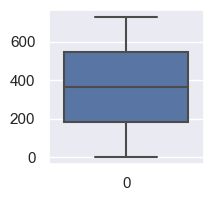

------ season -------


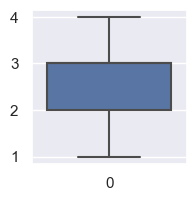

------ yr -------


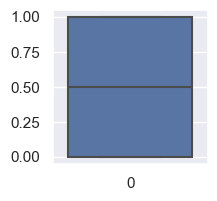

------ mnth -------


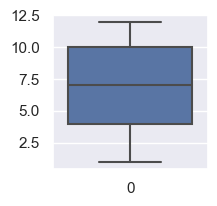

In [9]:
sns.set(rc={'figure.figsize':(2,2)})
for i in num_cols[:4]:
    print('------',i,'-------')
    sns.boxplot(data = df[i])
    plt.show()

##### E.3. Statistical technique (IRQ) to identify columns having outliers
IQR is the range between the first and the third quartiles namely Q1 and Q3: IQR = Q3 – Q1. The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers

In [10]:
#create a function to find outliers using IQR

def find_outliers_IQR(df, num_cols):
    #creating loop to take all numerical columns one-by-one and share outliers in them
    for i in num_cols:
        q1=df[i].quantile(0.25) #First quartile
        q3=df[i].quantile(0.75) #Third quartile
        IQR=q3-q1 #Difference
        
        outliers = df[((df[i]<(q1-1.5*IQR)) | (df[i]>(q3+1.5*IQR)))]
        
        print('In "',i,'" column',' no. of outlier are - ',len(outliers))

#Applying function on numerical columns 
find_outliers_IQR(df, num_cols)

In " instant " column  no. of outlier are -  0
In " season " column  no. of outlier are -  0
In " yr " column  no. of outlier are -  0
In " mnth " column  no. of outlier are -  0
In " holiday " column  no. of outlier are -  21
In " weekday " column  no. of outlier are -  0
In " workingday " column  no. of outlier are -  0
In " weathersit " column  no. of outlier are -  0
In " temp " column  no. of outlier are -  0
In " atemp " column  no. of outlier are -  0
In " hum " column  no. of outlier are -  2
In " windspeed " column  no. of outlier are -  13
In " casual " column  no. of outlier are -  44
In " registered " column  no. of outlier are -  0
In " cnt " column  no. of outlier are -  0


##### F) Variance in column values

In [12]:
print('Categorical columns')
for i in cat_cols:
    print('no. of unique values in',i,' - ',df[i].nunique())

Categorical columns
no. of unique values in dteday  -  730


In [13]:
print('Numerical columns')
for i in num_cols:
    print('no. of unique values in',i,' - ',df[i].nunique())

Numerical columns
no. of unique values in instant  -  730
no. of unique values in season  -  4
no. of unique values in yr  -  2
no. of unique values in mnth  -  12
no. of unique values in holiday  -  2
no. of unique values in weekday  -  7
no. of unique values in workingday  -  2
no. of unique values in weathersit  -  3
no. of unique values in temp  -  498
no. of unique values in atemp  -  689
no. of unique values in hum  -  594
no. of unique values in windspeed  -  649
no. of unique values in casual  -  605
no. of unique values in registered  -  678
no. of unique values in cnt  -  695


##### We can see there are few column having only 1 unqique value: 
delinq_2yrs, mths_since_last_delinq, pub_rec, etc.

### ** Insights From Data Understanding - Quality Check**
1. Rows and columns - 730 rows & 16 columns
2. Data Type: Most columns are float/integer except one column (Dteday)
3. Null value analysis - No null values in data
4. Outlier analysis - Based on IQR, few columns like "Holiday", "Windspeed", and "Casual" has some outliers
5. Variance analysis in column values: 
    1. Cat. col - No column having single values
    2. Num. col - Few numerical columns has only two unique values so they could be categorical columns
 


*****************************************************************************************************************************

### Data Exploration

#### 1. Numerical columns

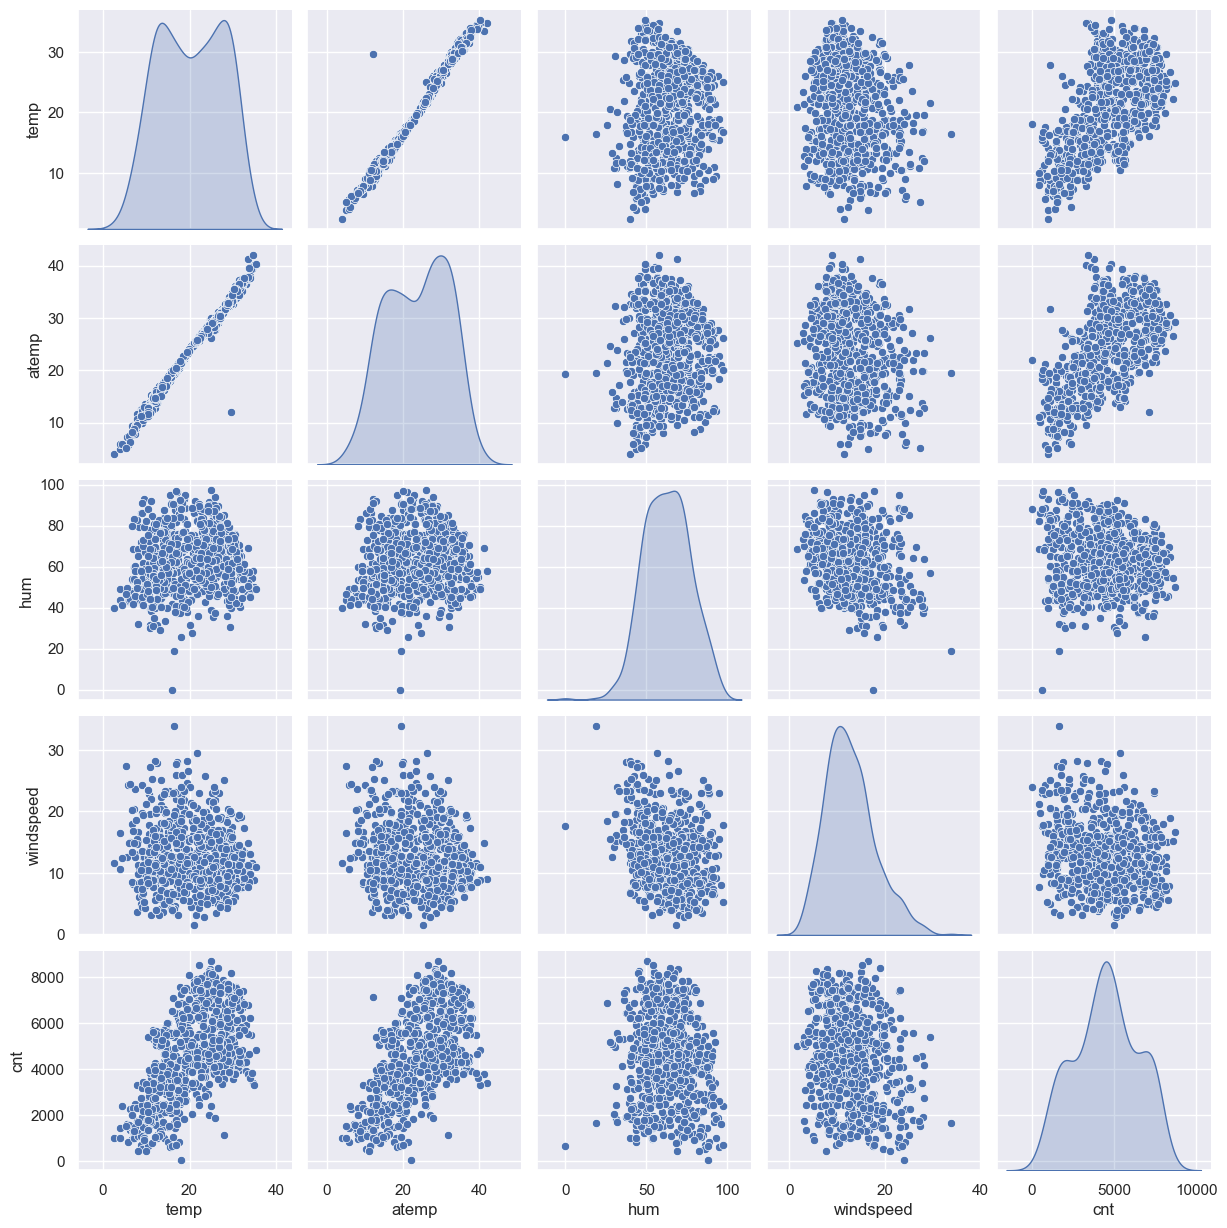

In [34]:
num_col_data=df[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]
sns.pairplot(num_col_data, diag_kind='kde')
plt.show()

#### 2. Categorical columns

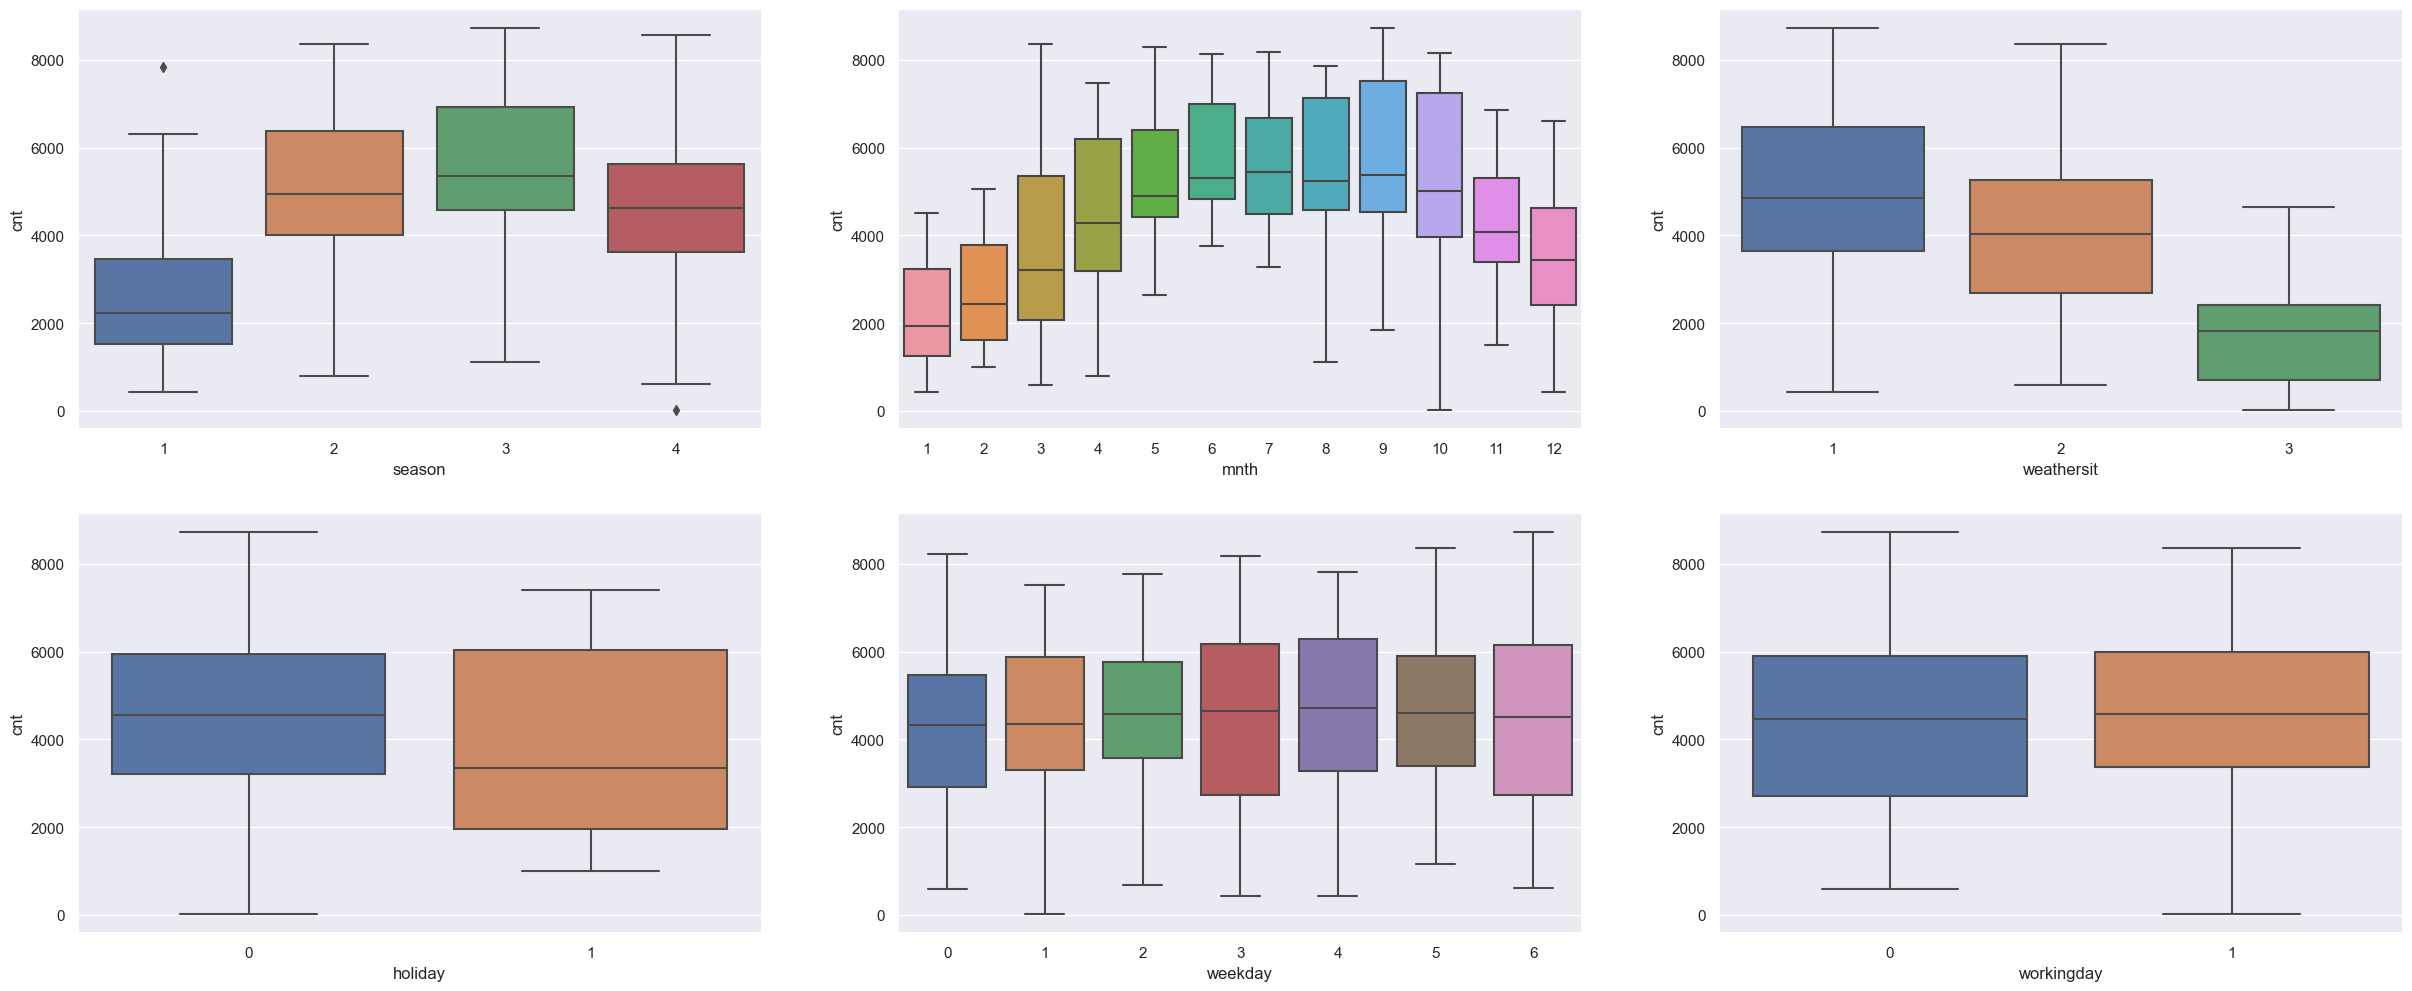

In [36]:
plt.figure(figsize=(30, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = df)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.show()


In [43]:
#Holiday
print(df['holiday'].value_counts(normalize=True))
print('---')
#Holiday
print(df['season'].value_counts(normalize=True))
print('---')
#Holiday
print(df['mnth'].value_counts(normalize=True))
print('---')
#Holiday
print(df['weathersit'].value_counts(normalize=True))
print('---')
#Holiday
print(df['weekday'].value_counts(normalize=True))
print('---')
#Holiday
print(df['workingday'].value_counts(normalize=True))

0   0.971
1   0.029
Name: holiday, dtype: float64
---
3   0.258
2   0.252
1   0.247
4   0.244
Name: season, dtype: float64
---
1    0.085
3    0.085
5    0.085
7    0.085
8    0.085
10   0.085
12   0.085
4    0.082
6    0.082
9    0.082
11   0.082
2    0.077
Name: mnth, dtype: float64
---
1   0.634
2   0.337
3   0.029
Name: weathersit, dtype: float64
---
6   0.144
0   0.144
1   0.144
2   0.142
4   0.142
5   0.142
3   0.141
Name: weekday, dtype: float64
---
1   0.684
0   0.316
Name: workingday, dtype: float64


### Correlation Matrix

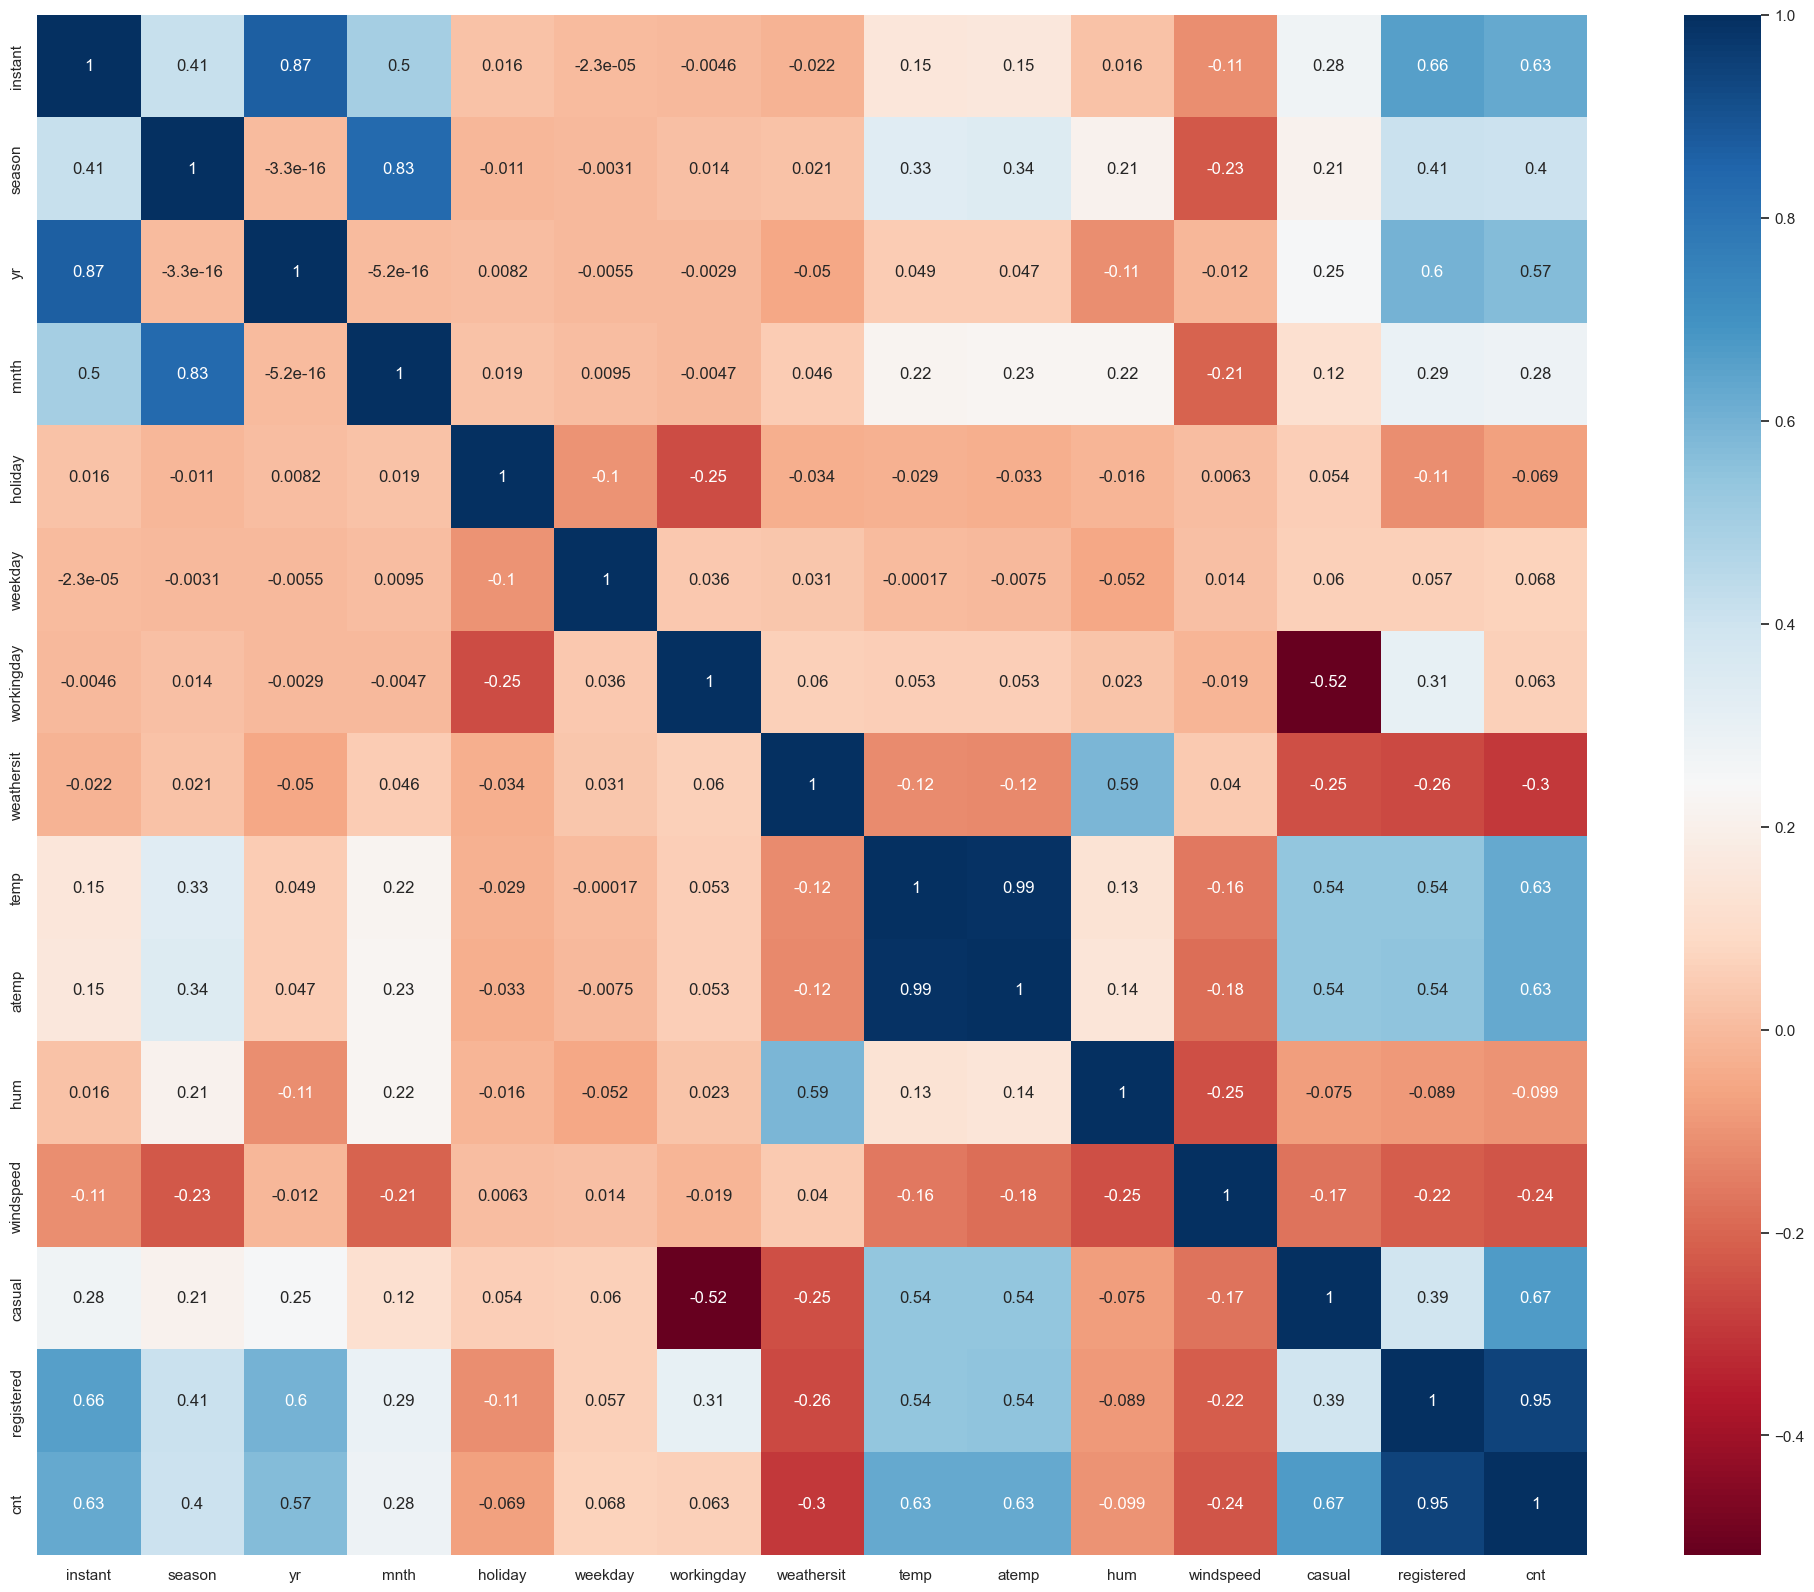

In [45]:
plt.figure(figsize = (25,20))
sns.heatmap(df.corr(), annot = True, cmap="RdBu")
plt.show()

### ** Insights From EDA**
1. Numerical columns
    1. Linear relationship b/w "Temp", "Cnt", and "Atemp"
2. Categorical columns:
    1. Seasons: More bookings are happening in Season 3 and then in Season 2
    2. Months: Between 6-10 months, the demand is high. The lowest demand in month 1
    3. Working days - There is no difference
    4. Holiday: 97% of bookings are on non-holodays
    5. weathersit: 63% are on when wathersit value is 1
    6. Working day: 68% of booking are on working days means people are using it for office

### Data Cleaning and manuplation

#### 1. Dropping non-essential columns:
    1. Instant - Index column
    2. Casual & Registred - As these are together counted under "Cnt" column
    3. dteday - We already have time factors in our data like month, year, working day, etc. so just date column would not be helpful

In [19]:
# Creating a new dataframe and dropping non-required columns
df_new = df.copy()
print('New dataframe shape - ',df_new.shape)
df_new.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)
print('New dataframe shape after dropping columns - ',df_new.shape)

New dataframe shape -  (730, 16)
New dataframe shape after dropping columns -  (730, 12)


#### 2. Create Dummy values : 
 1. Convert 4 categorical columns  - mnth, weekday, season & weathersit
As these are currently numerical so we will convert them into categorical data type and then into dummy variables

In [21]:
#Converting into categorical data type
df_new['season']=df_new['season'].astype('category')
df_new['weathersit']=df_new['weathersit'].astype('category')
df_new['mnth']=df_new['mnth'].astype('category')
df_new['weekday']=df_new['weekday'].astype('category')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    category
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(4), float64(4), int64(4)
memory usage: 49.7 KB


In [22]:
#Creating dummy variables
#Drop first -  will drop one column value so if there are two values in one categorical column (Men and Women) then it will create only one new column (Men or Women)
df_new = pd.get_dummies(df_new, drop_first=True) 
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            730 non-null    int64  
 1   holiday       730 non-null    int64  
 2   workingday    730 non-null    int64  
 3   temp          730 non-null    float64
 4   atemp         730 non-null    float64
 5   hum           730 non-null    float64
 6   windspeed     730 non-null    float64
 7   cnt           730 non-null    int64  
 8   season_2      730 non-null    uint8  
 9   season_3      730 non-null    uint8  
 10  season_4      730 non-null    uint8  
 11  mnth_2        730 non-null    uint8  
 12  mnth_3        730 non-null    uint8  
 13  mnth_4        730 non-null    uint8  
 14  mnth_5        730 non-null    uint8  
 15  mnth_6        730 non-null    uint8  
 16  mnth_7        730 non-null    uint8  
 17  mnth_8        730 non-null    uint8  
 18  mnth_9        730 non-null    

In [28]:
df_new.shape
print('After dummy variable creation: 12 columns > 30 columns')

After dummy variable creation: 12 columns > 30 columns


### Model preperation

#### 1. Splitting the data into train (70%) and test (30%)

In [31]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_new, train_size = 0.70, test_size = 0.30, random_state = 333)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(219, 30)


#### 2. Scaling - Using MinMax scaler to transform

In [47]:
### Rescaling the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#columns to rescale
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

### Model building

In [48]:
#Dropping target column from train data
y_train = df_train.pop('cnt')
X_train = df_train

In [58]:
print(y_train.shape)
print(X_train.shape)

(510,)
(510, 29)


#### 1. RFE - Recursive feature elimination

In [86]:
# Running RFE with the output number of the variable equal to 15
linr = LinearRegression()
linr.fit(X_train, y_train)

rfe_m = RFE(linr, n_features_to_select = 15)
rfe_m = rfe.fit(X_train, y_train)

In [87]:
list(zip(X_train.columns,rfe_m.support_,rfe_m.ranking_))

[('yr', True, 1),
 ('holiday', False, 14),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('mnth_2', False, 7),
 ('mnth_3', True, 1),
 ('mnth_4', False, 3),
 ('mnth_5', False, 2),
 ('mnth_6', False, 4),
 ('mnth_7', False, 15),
 ('mnth_8', False, 5),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 8),
 ('mnth_12', False, 9),
 ('weekday_1', False, 6),
 ('weekday_2', False, 13),
 ('weekday_3', False, 11),
 ('weekday_4', False, 12),
 ('weekday_5', False, 10),
 ('weekday_6', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

In [88]:
col_sel = X_train.columns[rfe_m.support_]
col_sel

Index(['yr', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_3', 'mnth_9', 'mnth_10', 'weekday_6',
       'weathersit_2', 'weathersit_3'],
      dtype='object')

In [89]:
X_train.columns[~rfe_m.support_]

Index(['holiday', 'mnth_2', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5'],
      dtype='object')

#### 3. Variance Inflation Factor (VIF)  - Measure multicollinearity in regression analysis.

In [90]:
# import library
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Save features with VIF scores
vif_score = pd.DataFrame()
X_train_rfe = X_train[col]
vif_score['Features'] = X_train_rfe.columns
vif_score['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif_score['VIF'] = round(vif_score['VIF'], 2)
vif_score = vif_score.sort_values(by = "VIF", ascending = False)
vif_score

,Features,VIF
2,temp,384.220
3,atemp,363.120
4,hum,17.520
7,season_3,7.090
5,windspeed,4.710
1,workingday,4.610
6,season_2,3.540
8,season_4,3.010
13,weathersit_2,2.140
0,yr,2.020


In [91]:
import statsmodels.api as sm

# Add a constant
X_train_lmodel1 = sm.add_constant(X_train_rfe)

# Create a first fitted model
lr_model1 = sm.OLS(y_train, X_train_lmodel1).fit()

In [92]:
# Check the parameters obtained

lr_model1.params

const           0.195
yr              0.229
workingday      0.041
temp            0.434
atemp           0.059
hum            -0.178
windspeed      -0.185
season_2        0.130
season_3        0.080
season_4        0.153
mnth_3          0.047
mnth_9          0.100
mnth_10         0.054
weekday_6       0.055
weathersit_2   -0.047
weathersit_3   -0.271
dtype: float64

In [93]:
# Print a summary of the linear regression model obtained
print(lr_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     175.1
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          1.28e-186
Time:                        23:21:13   Log-Likelihood:                 509.26
No. Observations:                 510   AIC:                            -986.5
Df Residuals:                     494   BIC:                            -918.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1953      0.030      6.576   

## Insights
1. R-squared: 0.842 Model is doing a good job
2. Adj. R-squared:0.837 Having close to R-square means number of feature are good n explaining variability
3. F-statistic (overall significance of the Model) : 175.1 (it's also good)

## Model 2 - Experiment
 - High p-value & VIF score- Delete columns "atemp" 

In [94]:
X_train_new = X_train_rfe.drop(["atemp"], axis = 1)

In [95]:
# Save features with VIF scores
vif_score2 = pd.DataFrame()
vif_score2['Features'] = X_train_new.columns
vif_score2['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif_score2['VIF'] = round(vif_score2['VIF'], 2)
vif_score2 = vif_score2.sort_values(by = "VIF", ascending = False)
vif_score2

,Features,VIF
2,temp,23.210
3,hum,17.230
6,season_3,7.010
1,workingday,4.600
4,windspeed,4.550
5,season_2,3.540
7,season_4,3.010
12,weathersit_2,2.140
0,yr,2.020
11,weekday_6,1.790


In [96]:
# Add a constant
X_train_lm_model2 = sm.add_constant(X_train_new)

# Create a first fitted model
lr_model2 = sm.OLS(y_train, X_train_lm_model2).fit()

In [97]:
lr_model2.params

const           0.196
yr              0.229
workingday      0.041
temp            0.489
hum            -0.178
windspeed      -0.187
season_2        0.130
season_3        0.079
season_4        0.154
mnth_3          0.047
mnth_9          0.100
mnth_10         0.054
weekday_6       0.055
weathersit_2   -0.048
weathersit_3   -0.272
dtype: float64

In [98]:
print(lr_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     187.9
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          1.00e-187
Time:                        23:26:50   Log-Likelihood:                 509.17
No. Observations:                 510   AIC:                            -988.3
Df Residuals:                     495   BIC:                            -924.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1962      0.030      6.627   

#### Model Improvements
1. F statistics changed from 175 > 184

## ** Insights**

1. F Statistics (overall model performance): 184
2. Prob (F-statistic): 1.00e-187
   Both of the metrics combined states shows model is significant

### Imp. feature explanations

1. temp (Cofficent -  0.4893) : Shows that a unit increase in temp variable, increases the bike hire numbers by 0.4893 units.
2. weathersit_3 (Cofficent -  -0.2715): Shows that a unit increase in Weathersit_3 variable, decreases the bike hire numbers by 0.2715 units.
3. yr (Cofficent -  0.2287): Shows that a unit increase in yr variable, increases the bike hire numbers by 0.2287 units.
5. windspeed (Cofficent -0.1872): Shows that a unit increase in windspeed variable decreases the bike hire numbers by 0.1872 units.

### Assumption - 
It should be normally distributed with mean zere

In [99]:
y_train_pred = lr_model2.predict(X_train_lm2)

C:\Users\tyagittt\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

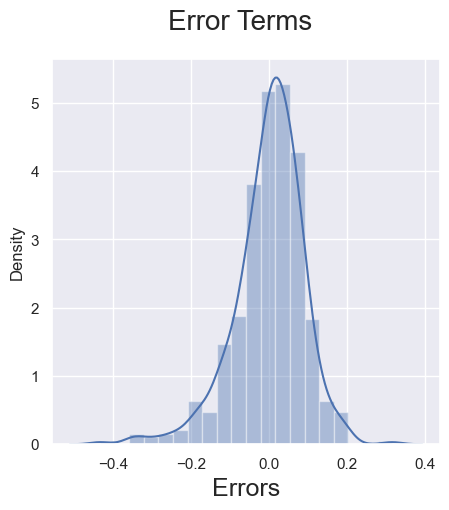

In [103]:
sns.set(rc={'figure.figsize':(5,5)})
res = y_train-y_train_pred
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  


In [80]:
y_test = df_test.pop('cnt')
X_test = df_test
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 22 to 313
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            219 non-null    int64  
 1   holiday       219 non-null    int64  
 2   workingday    219 non-null    int64  
 3   temp          219 non-null    float64
 4   atemp         219 non-null    float64
 5   hum           219 non-null    float64
 6   windspeed     219 non-null    float64
 7   season_2      219 non-null    uint8  
 8   season_3      219 non-null    uint8  
 9   season_4      219 non-null    uint8  
 10  mnth_2        219 non-null    uint8  
 11  mnth_3        219 non-null    uint8  
 12  mnth_4        219 non-null    uint8  
 13  mnth_5        219 non-null    uint8  
 14  mnth_6        219 non-null    uint8  
 15  mnth_7        219 non-null    uint8  
 16  mnth_8        219 non-null    uint8  
 17  mnth_9        219 non-null    uint8  
 18  mnth_10       219 non-null   

In [81]:
#Selecting the variables that were part of final model.
col1=X_train_new.columns
X_test=X_test[col1]
# Adding constant variable to test dataframe
X_test_lm6 = sm.add_constant(X_test)
X_test_lm6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 22 to 313
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         219 non-null    float64
 1   yr            219 non-null    int64  
 2   workingday    219 non-null    int64  
 3   temp          219 non-null    float64
 4   hum           219 non-null    float64
 5   windspeed     219 non-null    float64
 6   season_2      219 non-null    uint8  
 7   season_3      219 non-null    uint8  
 8   season_4      219 non-null    uint8  
 9   mnth_3        219 non-null    uint8  
 10  mnth_9        219 non-null    uint8  
 11  mnth_10       219 non-null    uint8  
 12  weekday_6     219 non-null    uint8  
 13  weathersit_2  219 non-null    uint8  
 14  weathersit_3  219 non-null    uint8  
dtypes: float64(4), int64(2), uint8(9)
memory usage: 13.9 KB


In [83]:
# Making predictions using the final model (lr6)
X_test_lm2 = sm.add_constant(X_test)
X_test_lm2.info()
y_pred = lr2.predict(X_test_lm2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 22 to 313
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         219 non-null    float64
 1   yr            219 non-null    int64  
 2   workingday    219 non-null    int64  
 3   temp          219 non-null    float64
 4   hum           219 non-null    float64
 5   windspeed     219 non-null    float64
 6   season_2      219 non-null    uint8  
 7   season_3      219 non-null    uint8  
 8   season_4      219 non-null    uint8  
 9   mnth_3        219 non-null    uint8  
 10  mnth_9        219 non-null    uint8  
 11  mnth_10       219 non-null    uint8  
 12  weekday_6     219 non-null    uint8  
 13  weathersit_2  219 non-null    uint8  
 14  weathersit_3  219 non-null    uint8  
dtypes: float64(4), int64(2), uint8(9)
memory usage: 13.9 KB


In [ ]:
Model Evaluation

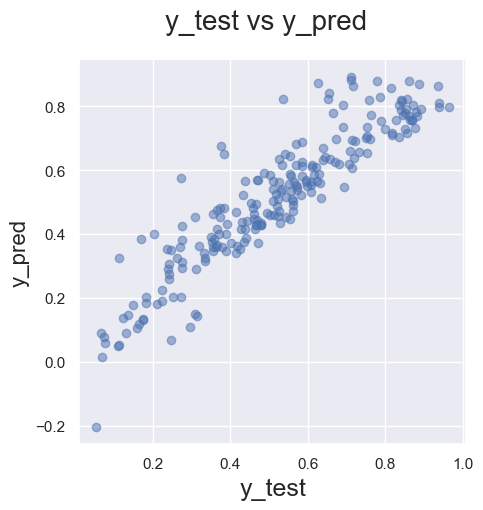

In [107]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred, alpha=.5)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 
plt.show()

### Rsquare test

In [85]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.833487219415617